## Table of Contents

## Imports

In [1]:
import pandas as pd
from catboost import CatBoostRegressor, Pool

from ray.tune.search.hyperopt import HyperOptSearch
from ray import tune

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate

import seaborn as sns
from matplotlib import pyplot as plt

from src.model_data.main import RunAllMethods
from src.ray_tuning.ray_tune import RayTune

## Pull Data

In [2]:
# seasons = list(range(2018, 2024))
# end_date = '2023-07-15'

# driver_class = RunAllMethods(seasons, end_date)
# all_seasons = pd.DataFrame()

# for season in driver_class:
#     all_seasons = pd.concat([all_seasons, season])

In [3]:
# all_seasons.to_csv('data/full_run_7_15.csv', index=False)

## Things to do/fix

1) Case when a driver has multiple control messsages in a session
2) Add docstrings:
    - ray tune

## Load Data

In [4]:
season_df = pd.read_csv('data/full_run_7_15.csv')
season_df

,Driver,DriverNumber,Time_min,Time_max,LapTimeSeconds_min,LapTimeSeconds_max,LapTimeSeconds_mean,LapTimeSeconds_std,LapTimeSeconds_count,Sector1TimeSeconds_min,...,TeamId,CountryCode,SessionType,SeasonYear,EventName,Position,Points,Country,Location,RoundNumber
0,ALO,14,0 days 00:30:47.908000,0 days 01:39:12.964000,85.896,115.334,93.453545,9.393776,11,28.485,...,mclaren,NaN,Practice 1,2018,Australian Grand Prix,5.0,10.0,Australia,Melbourne,1
1,ALO,14,0 days 00:12:20.531000,0 days 01:38:57.172000,85.200,148.222,98.449000,14.802200,23,28.165,...,mclaren,NaN,Practice 2,2018,Australian Grand Prix,5.0,10.0,Australia,Melbourne,1
2,ALO,14,0 days 00:23:58.601000,0 days 01:05:05.890000,94.298,122.320,105.187667,10.557891,9,30.927,...,mclaren,NaN,Practice 3,2018,Australian Grand Prix,5.0,10.0,Australia,Melbourne,1
3,BOT,77,0 days 00:25:57.761000,0 days 01:39:48.848000,84.577,122.941,96.972792,13.029348,24,28.037,...,mercedes,NaN,Practice 1,2018,Australian Grand Prix,8.0,4.0,Australia,Melbourne,1
4,BOT,77,0 days 00:12:42.794000,0 days 01:39:37.880000,84.159,130.373,96.584207,12.853744,29,27.725,...,mercedes,NaN,Practice 2,2018,Australian Grand Prix,8.0,4.0,Australia,Melbourne,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8172,VER,1,0 days 00:18:01.997000,0 days 01:32:24.572000,86.720,149.043,102.406167,19.142776,18,27.482,...,NaN,NED,Qualifying,2023,British Grand Prix,NaN,NaN,Great Britain,Silverstone,10
8173,ZHO,24,0 days 00:18:43.533000,0 days 01:20:10.645000,90.321,138.955,110.773438,19.255330,16,28.643,...,NaN,CHN,Practice 1,2023,British Grand Prix,NaN,NaN,Great Britain,Silverstone,10
8174,ZHO,24,0 days 00:14:59.065000,0 days 01:18:21.441000,89.225,147.762,108.462958,20.327231,24,28.165,...,NaN,CHN,Practice 2,2023,British Grand Prix,NaN,NaN,Great Britain,Silverstone,10
8175,ZHO,24,0 days 00:27:48.361000,0 days 00:29:41.530000,113.169,113.169,113.169000,NaN,1,30.774,...,NaN,CHN,Practice 3,2023,British Grand Prix,NaN,NaN,Great Britain,Silverstone,10


## Data Preperation

In [5]:
# Drop unneeded columns and remove driver session's with undefined points
model_data = season_df.drop(['Time_min', 'Time_max'], axis=1).copy()
model_data = model_data.dropna(subset=['Points'])

# List of categorical features
categorical_features = ['Driver', 'DriverNumber', 'Category', 'TeamId',
                        'CountryCode', 'Country', 'Location', 'EventName',
                        'SessionType', 'SeasonYear']

# List of integer features
integer_features = ['IsPersonalBest_pr_lap', 'RoundNumber', 'SeasonYear']

# List of float features
float_features = list(set(model_data.columns) - 
                      set(categorical_features) - 
                      set(integer_features))

# Convert categorical features to object
for feature in categorical_features:
    model_data[feature] = model_data[feature].astype(object)

# Convert integer features to int
for feature in integer_features:
    model_data[feature] = model_data[feature].astype(int)

# Convert float features to float
for feature in float_features:
    model_data[feature] = model_data[feature].astype(float)

In [6]:
# Fill na for categorical featues with '-1'
model_data.loc[:,model_data.dtypes == object] = (
    model_data.loc[:,model_data.dtypes == object].fillna('-1')
)

# Fill all other numerical feature na's with -1
model_data.loc[:,model_data.dtypes != object] = (
    model_data.loc[:,model_data.dtypes != object].fillna(-1)
)

## Exploratory Data Analysis (EDA)

In [7]:
def get_points_charts(feature, mean_title, sum_title, query):

    # Query to grain of data based on feature - Per Driver, Season, and Event
    feature_df = (
        model_data.query(query)
                  .copy()
                  .groupby(['Driver',
                            'SeasonYear',
                            'EventName',
                            f'{feature}'])['Points']
                  .mean()
                  .reset_index()
    )

    # Mean and sum of metric
    feature_agg = (
        feature_df.groupby([f'{feature}',
                            'SeasonYear'])['Points']
                  .agg({'mean', 'sum'})
                  .reset_index()
    )

    # Plot Barplots
    fig = plt.figure()
    plt.style.use('ggplot')
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    sns.barplot(feature_agg.sort_values('mean', ascending=False),
                x='mean',
                y=f'{feature}',
                hue='SeasonYear',
                ax=ax1)
    ax1.title.set_text(mean_title)
    ax1.set_ylabel('Average Points')
    sns.barplot(feature_agg.sort_values('sum', ascending=False),
                x='sum',
                y=f'{feature}',
                hue='SeasonYear',
                ax=ax2)
    ax2.title.set_text(sum_title)
    ax2.set_ylabel('Total Points')
    sns.set(rc={'figure.figsize':(30, 20)})

    plt.show()

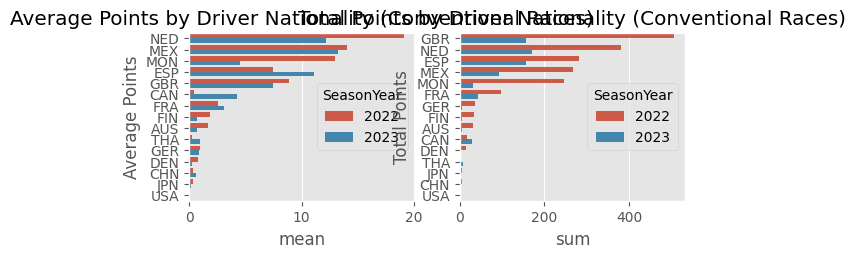

In [8]:
mean_title = 'Average Points by Driver Nationality (Conventional Races)'
sum_title = 'Total Points by Driver Nationality (Conventional Races)'
query = '(CountryCode != "-1") and SeasonYear >= 2022'
get_points_charts('CountryCode', mean_title, sum_title, query)

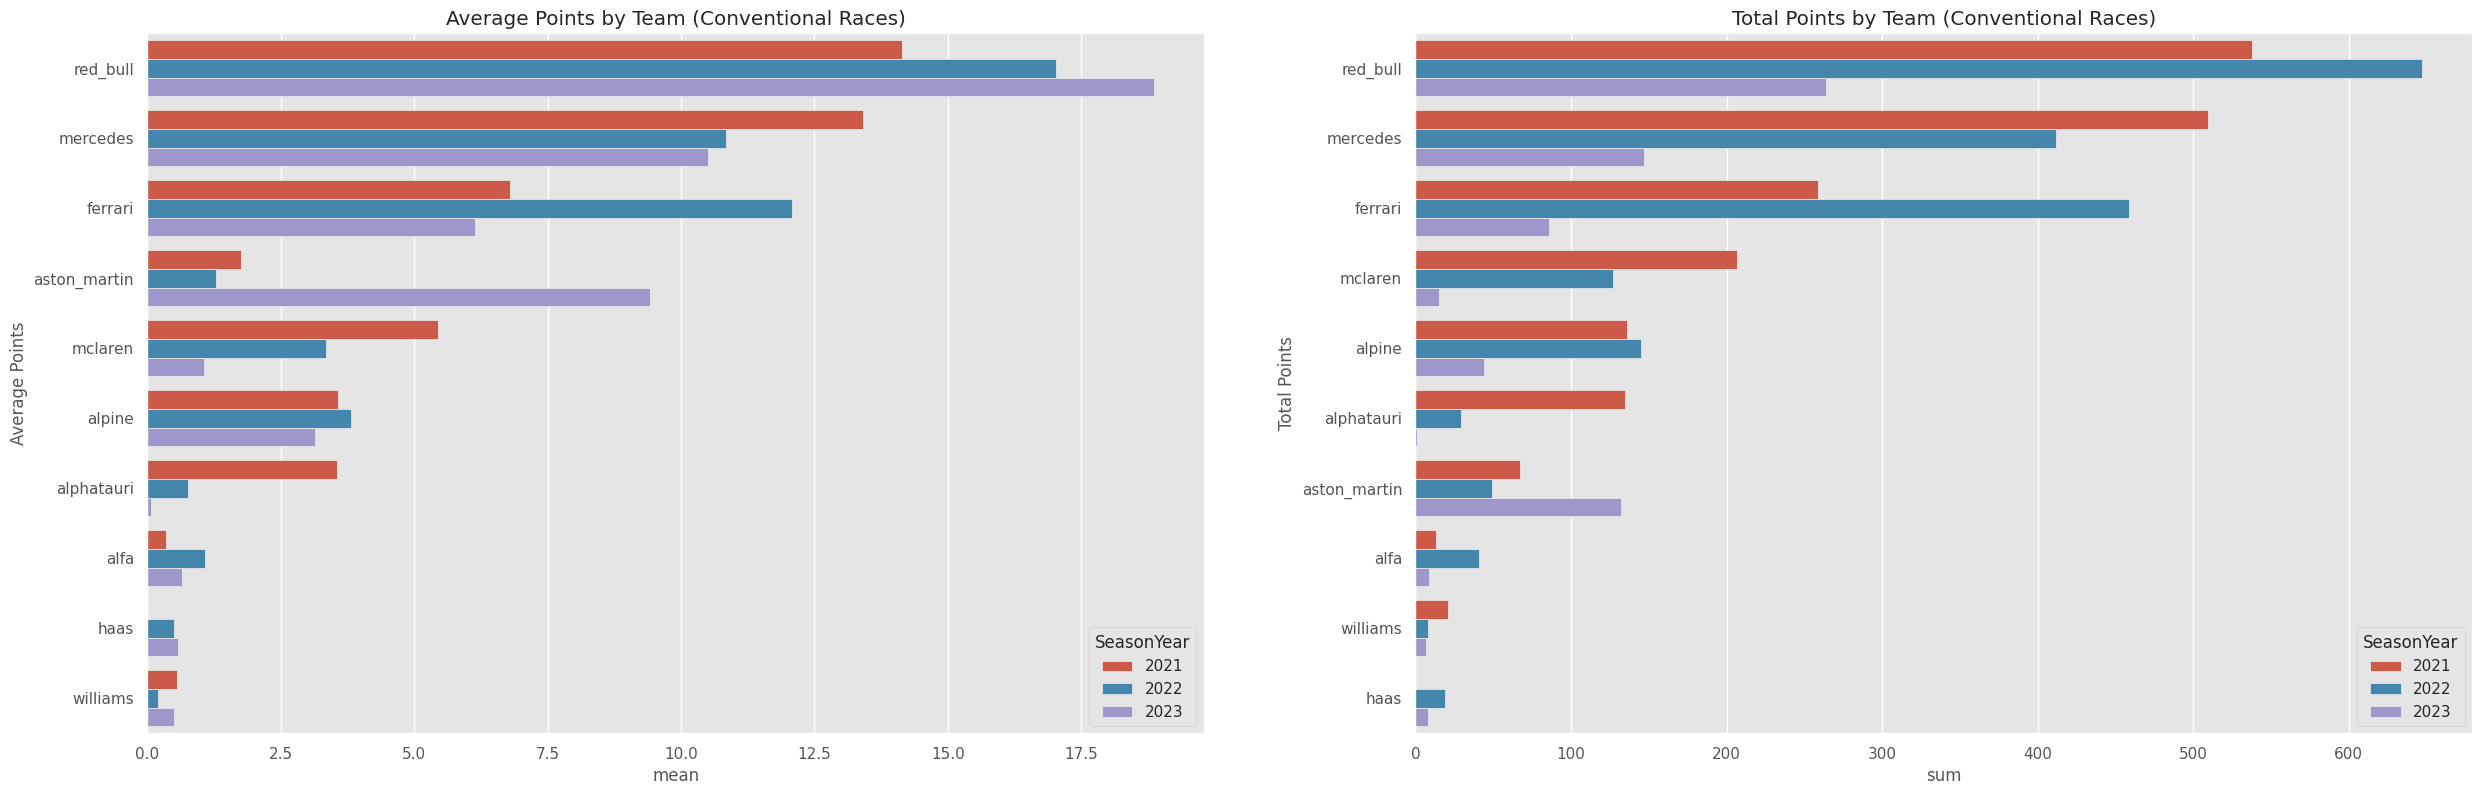

In [9]:
mean_title = 'Average Points by Team (Conventional Races)'
sum_title = 'Total Points by Team (Conventional Races)'
query = 'SeasonYear >= 2021'
get_points_charts('TeamId', mean_title, sum_title, query)

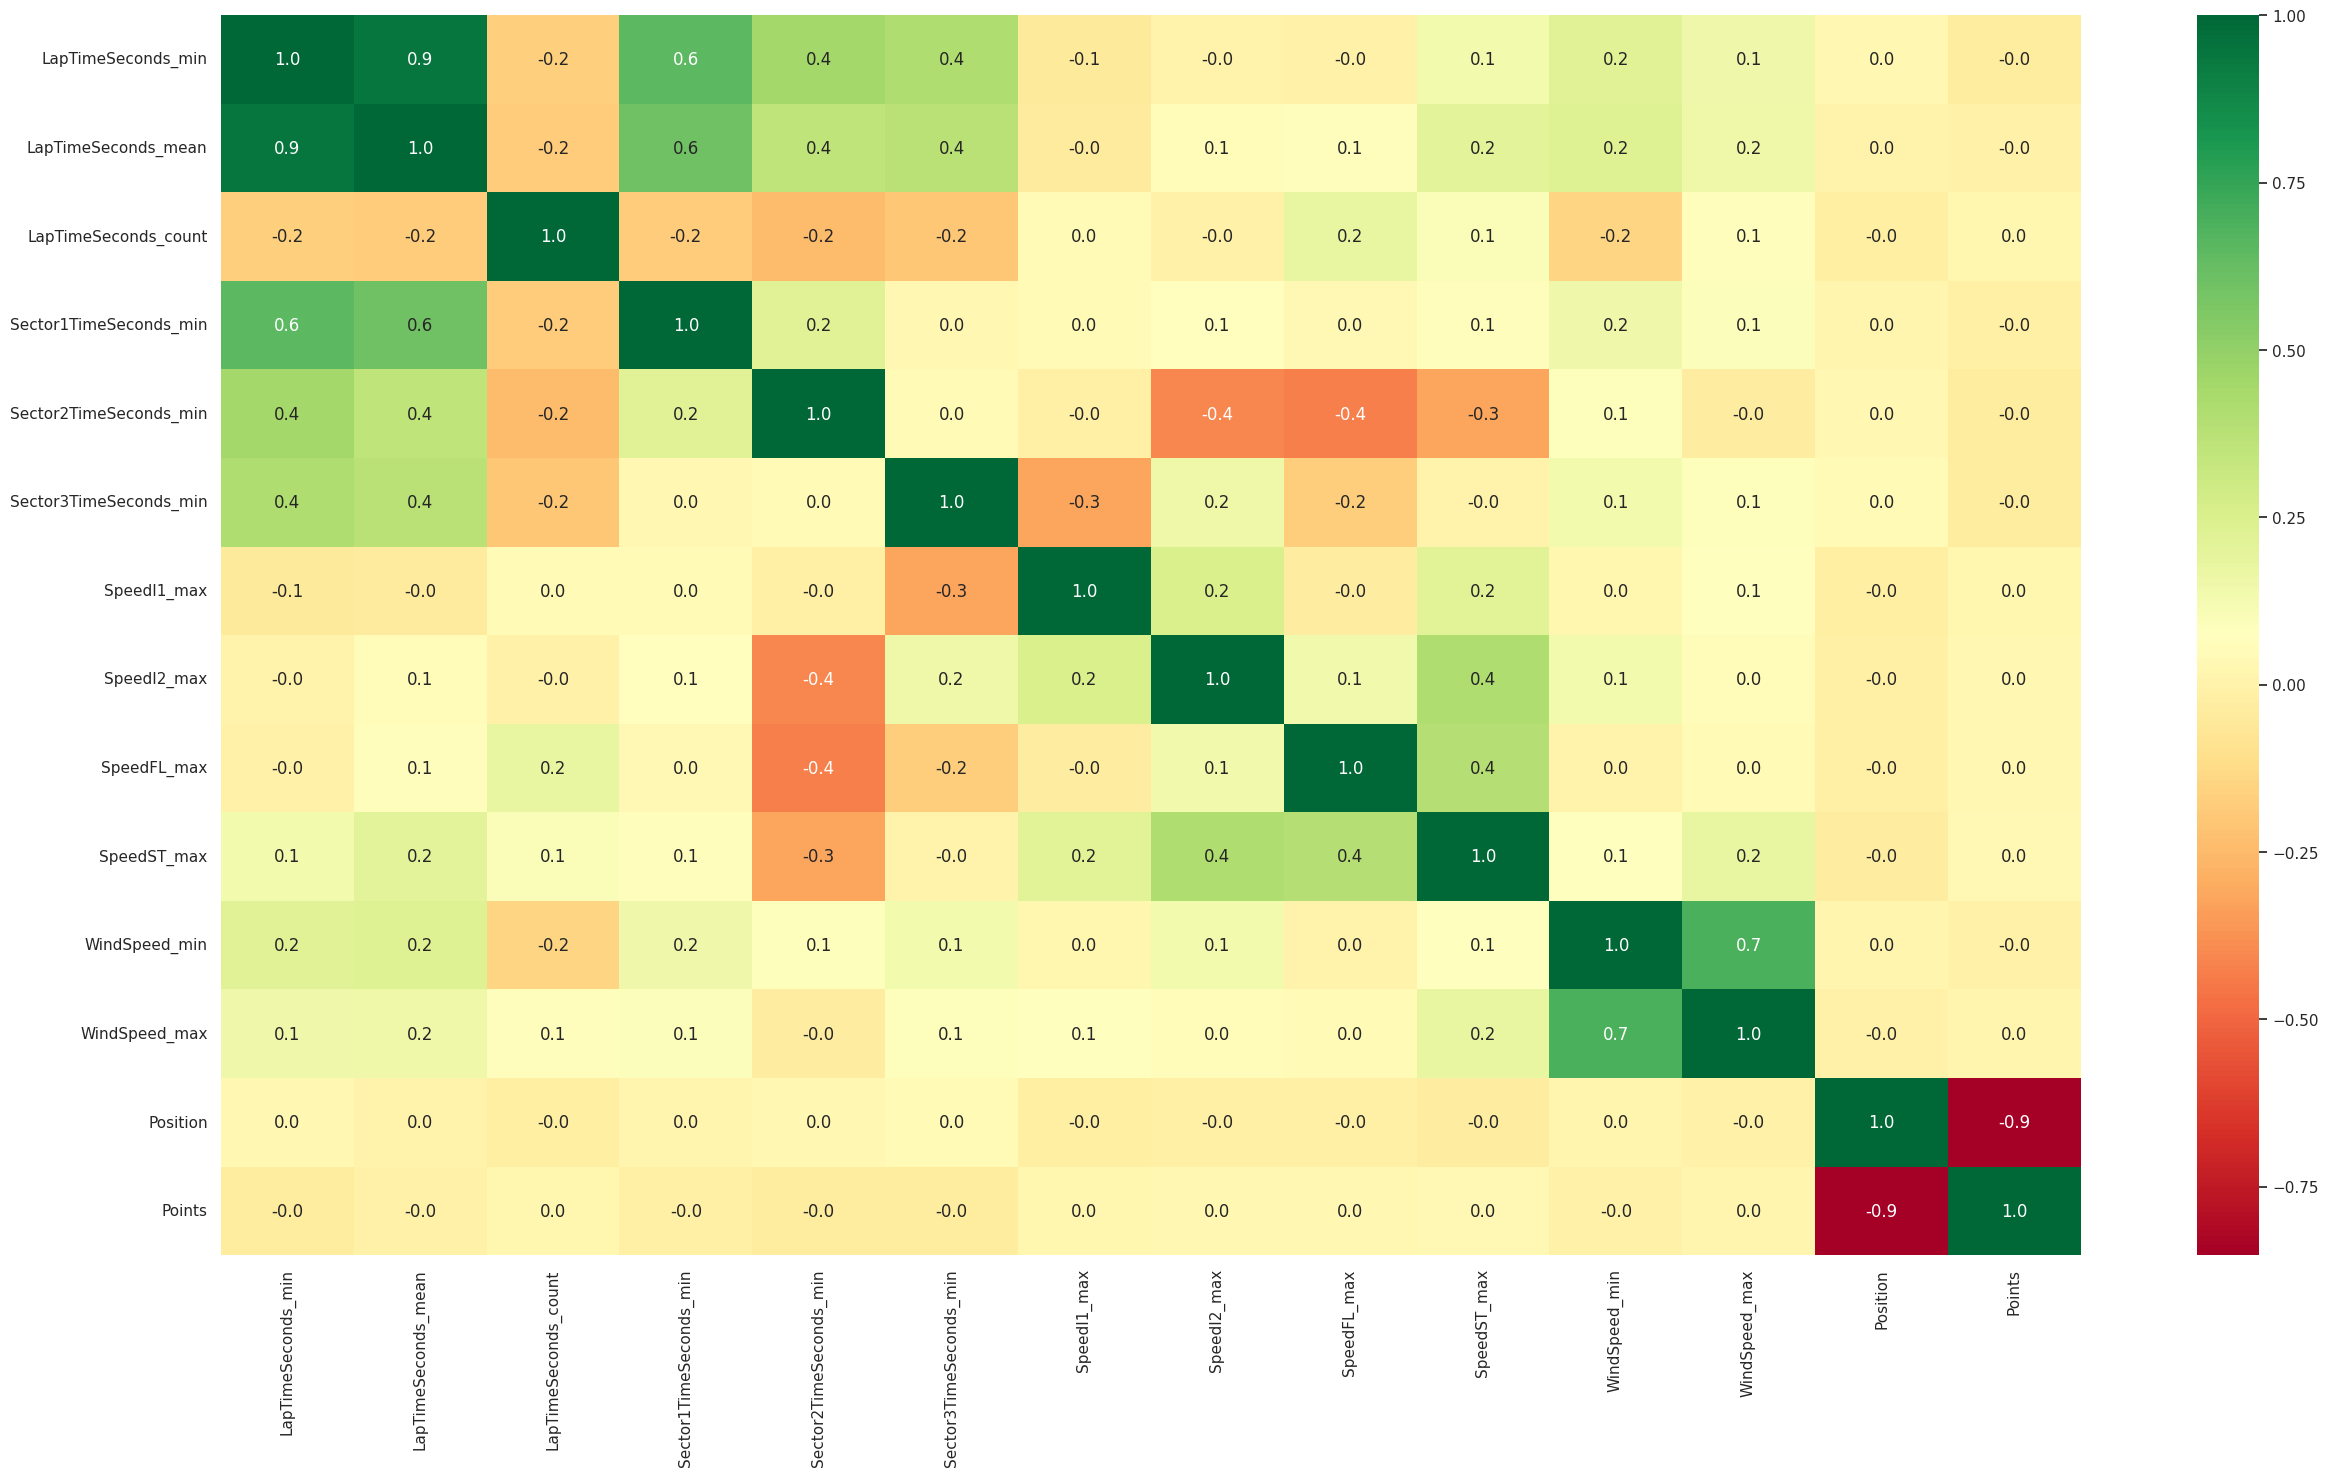

In [10]:
# Only use select features for correlation matrix. Based on personal discretion
corr_select_features = ['LapTimeSeconds_min', 'LapTimeSeconds_mean', 
                        'LapTimeSeconds_count', 'Sector1TimeSeconds_min', 'Sector2TimeSeconds_min', 'Sector3TimeSeconds_min',
                        'SpeedI1_max', 'SpeedI2_max', 'SpeedFL_max', 'SpeedST_max', 'WindSpeed_min', 'WindSpeed_max', 'Position', 'Points']

# Correlation calculations
corr_original = (
    model_data.select_dtypes(['int', 'float'])[corr_select_features]
    .corr().abs()
)

# Graph heatmap of original correlation matrix
ax = (
    sns.heatmap(model_data
                .select_dtypes(['int','float'])[corr_original.index]
                .corr(),
                annot=True,
                cmap='RdYlGn',
                fmt='1.1f')
)
plt.subplots_adjust(bottom=0.26)
plt.show()

## Feature Selection

In [11]:
# TODO: Feature Selection

## Data Split

In [12]:
# Unique train test split. It is most helpful to include entire events in the 
# test data to see how things would have been if the model was used. Basically 
# any event after 2023 - Round 5 is used in the Test. Anything before is used 
# for train/validation
train_data = model_data.query('SeasonYear < 2023 or RoundNumber < 5')
test_data = model_data.query('RoundNumber >= 5 & SeasonYear == 2023')

In [13]:
# Points as response variable 
X = train_data.drop(['Points'], axis=1)
y = train_data.Points

# Train/Validation split
X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y, 
                                                  test_size=0.2,
                                                  stratify=X['Position'])

# Prepare test data
X_test = test_data.drop(['Points', 'Position'], axis=1)
y_test = test_data.Points

X_train = X_train.drop(['Position'], axis=1)
X_val = X_val.drop(['Position'], axis=1)

In [14]:
# Define categorical feature indices
categorical_columns_indices = [i for i, dtype in enumerate(X_train.dtypes) 
                               if dtype == object]

In [15]:
# Catboost specific Pool object for train and validation data
train_pool = Pool(X_train, y_train, cat_features=categorical_columns_indices)
val_pool = Pool(X_val, y_val, cat_features=categorical_columns_indices)

## Hyperparameter Optimization

In [16]:
# Hyperparameter space to select from. Following 5 parameters are what appear 
# to be most useful for catboost
# TODO: Add catboost regression computing power split
space = {
    "learning_rate": tune.loguniform(1e-2, 1),
    "depth": tune.randint(4, 12),
    "l2_leaf_reg": tune.randint(1, 40),
    "min_data_in_leaf": tune.randint(1, 40),
    "iterations": tune.randint(10, 300),
    "thread_count": 4,
    "gpu_ram_part": 0.2,
    "task_type": "GPU"
}

train_data = (X_train, y_train)
validation_data = (X_val, y_val)

# Structure of data passed into ray tune objective function
data = {'train_data': train_data,
        'validation_data': validation_data,
        'model_module': 'catboost',
        'model_class_str': 'CatBoostRegressor',
        'fit_params': {
            'early_stopping_rounds': 2,
            'verbose': False,
            'cat_features': categorical_columns_indices,
            'eval_set': validation_data,
        },
        'metric_class_str': 'mean_squared_error',
        'metric_params': {'squared': False},
        'probability': False
        }

# Search algorithm: HyperOpt uses Tree of Parzen Estimator, a bayesian 
# optimization technique 
hyperopt_search = HyperOptSearch(metric="mean_squared_error", mode="min")

In [17]:
# Ray tune class from src/ray_tuning/ray_tune.py
tuning_class = RayTune(hyperopt_search, space, data)

# Tuner method requires gpu, cpu configuration, max concurrent trials, and 
# total number of samples to optimize with
tuning_config = {'num_gpus': 1}
cpu_per_trial = 4
gpu_per_trial = 0.2
max_concurrent_trials = 4
num_samples = 100

# Results from tuning
results = (
    tuning_class.tuner(tuning_config,
                       max_concurrent_trials,
                       num_samples,
                       cpu_per_trial,
                       gpu_per_trial)
)

2023-07-26 22:36:13,723	INFO worker.py:1627 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Trial name,date,done,hostname,iterations_since_restore,mean_squared_error,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,training_iteration,trial_id
objective_02732436,2023-07-26_22-36-23,True,jbalda-B660-GAMING-X-AX-DDR4,1,4.56877,192.168.0.162,96549,4.04105,4.04105,4.04105,1690425383,1,02732436
objective_2e1d98c8,2023-07-26_22-36-20,True,jbalda-B660-GAMING-X-AX-DDR4,1,4.50279,192.168.0.162,96774,1.98996,1.98996,1.98996,1690425380,1,2e1d98c8
objective_39679f66,2023-07-26_22-36-21,True,jbalda-B660-GAMING-X-AX-DDR4,1,4.37041,192.168.0.162,97012,2.98997,2.98997,2.98997,1690425381,1,39679f66
objective_55f025c0,2023-07-26_22-36-15,True,jbalda-B660-GAMING-X-AX-DDR4,1,6.3885,192.168.0.162,96151,0.233484,0.233484,0.233484,1690425375,1,55f025c0
objective_5be5583c,2023-07-26_22-36-15,True,jbalda-B660-GAMING-X-AX-DDR4,1,4.77523,192.168.0.162,96151,0.587153,0.587153,0.587153,1690425375,1,5be5583c
objective_67770434,2023-07-26_22-36-15,True,jbalda-B660-GAMING-X-AX-DDR4,1,5.00021,192.168.0.162,96151,0.102571,0.102571,0.102571,1690425375,1,67770434
objective_9ed4d8a0,2023-07-26_22-36-17,True,jbalda-B660-GAMING-X-AX-DDR4,1,4.68152,192.168.0.162,96549,1.06038,1.06038,1.06038,1690425377,1,9ed4d8a0
objective_ab7db925,2023-07-26_22-36-18,True,jbalda-B660-GAMING-X-AX-DDR4,1,4.45336,192.168.0.162,96774,1.26931,1.26931,1.26931,1690425378,1,ab7db925
objective_c6af545e,2023-07-26_22-36-15,True,jbalda-B660-GAMING-X-AX-DDR4,1,4.76659,192.168.0.162,96151,0.130208,0.130208,0.130208,1690425375,1,c6af545e
objective_cc8f392a,2023-07-26_22-36-19,True,jbalda-B660-GAMING-X-AX-DDR4,1,5.63741,192.168.0.162,96549,1.41192,1.41192,1.41192,1690425379,1,cc8f392a


(objective pid=96549) Warning: less than 75% gpu memory available for training. Free: 5723.6875 Total: 7982.4375
(objective pid=97012) Warning: less than 75% gpu memory available for training. Free: 3933.625 Total: 7982.4375 [repeated 8x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(objective pid=97012) Warning: less than 75% gpu memory available for training. Free: 3888.625 Total: 7982.4375 [repeated 5x across cluster]
(objective pid=96151) Warning: less than 75% gpu memory available for training. Free: 4496.75 Total: 7982.4375 [repeated 4x across cluster]
(objective pid=96549) Warning: less than 75% gpu memory available for training. Free: 4291.125 Total: 7982.4375
(objective pid=97012) Warning: less than 75% gpu memory available for training. Free: 4328 Total: 7982.4375
(objective pid=96151) Warning: less than 75% gpu m

In [18]:
# Best result of optimization
best_result = results.get_best_result(metric='mean_squared_error', mode='min')
params = best_result.config
params

{'learning_rate': 0.04018590888878337,
 'depth': 11,
 'l2_leaf_reg': 1,
 'min_data_in_leaf': 2,
 'iterations': 209,
 'thread_count': 4,
 'gpu_ram_part': 0.2,
 'task_type': 'GPU'}

In [18]:
params = {'learning_rate': 0.04018590888878337,
 'depth': 11,
 'l2_leaf_reg': 1,
 'min_data_in_leaf': 2,
 'iterations': 209,
 'thread_count': 4,
 'gpu_ram_part': 0.2,
 'task_type': 'GPU'}

## Cross Validation and Final Model Training

In [19]:
final_model = CatBoostRegressor(**params,
                                eval_metric='RMSE')

cross_val = cross_validate(final_model,
                           X_train,
                           y_train,
                           fit_params={
                               'eval_set': val_pool,
                               'cat_features': categorical_columns_indices,
                               'verbose': False,
                               'plot': True
                               },
                           scoring='neg_root_mean_squared_error',
                           cv=5,
                           return_train_score=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [20]:
print(
    f"Train RMSE: {-1*cross_val['train_score'].mean()} \u00B1 {cross_val['train_score'].std()}"
)

print(
    f"Test RMSE: {-1*cross_val['test_score'].mean()} \u00B1 {cross_val['test_score'].std()}"
)

Train RMSE: 2.7625285594375493 ± 0.03569781598589506
Test RMSE: 4.081193141970106 ± 0.15353897284553358


In [23]:
final_model.fit(train_pool,
                eval_set=val_pool,
                plot=True,
                early_stopping_rounds=5)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 7.2495457	test: 7.2149676	best: 7.2149676 (0)	total: 2.34ms	remaining: 23.4ms
1:	learn: 7.2198320	test: 7.1842461	best: 7.1842461 (1)	total: 5.9ms	remaining: 26.6ms
2:	learn: 7.1888264	test: 7.1522383	best: 7.1522383 (2)	total: 7.95ms	remaining: 21.2ms
3:	learn: 7.1590744	test: 7.1218952	best: 7.1218952 (3)	total: 9.99ms	remaining: 17.5ms
4:	learn: 7.1287652	test: 7.0909620	best: 7.0909620 (4)	total: 12.4ms	remaining: 14.9ms
5:	learn: 7.0978034	test: 7.0590192	best: 7.0590192 (5)	total: 14.5ms	remaining: 12.1ms
6:	learn: 7.0683979	test: 7.0289265	best: 7.0289265 (6)	total: 16.5ms	remaining: 9.41ms
7:	learn: 7.0380526	test: 6.9965853	best: 6.9965853 (7)	total: 18.5ms	remaining: 6.94ms
8:	learn: 7.0081716	test: 6.9656683	best: 6.9656683 (8)	total: 22.3ms	remaining: 4.95ms
9:	learn: 6.9788902	test: 6.9350881	best: 6.9350881 (9)	total: 24.3ms	remaining: 2.43ms
10:	learn: 6.9521428	test: 6.9066264	best: 6.9066264 (10)	total: 26.3ms	remaining: 0us
bestTest = 6.906626397
bestIterati

## Feature Importance

In [96]:
feature_importance = (
    pd.DataFrame({'Feature': final_model.feature_names_, 
                  'Importance': final_model.feature_importances_})
)

feature_importance_sorted = (
    feature_importance
    .sort_values('Importance', ascending=False)
    .reset_index(drop=True)
)
feature_importance_sorted.iloc[0:20]

,Feature,Importance
0,TeamId,23.648401
1,Driver,8.949161
2,DriverNumber,8.406043
3,SeasonYear,5.724289
4,CountryCode,4.885298
5,EventName,3.691378
6,Country,2.559245
7,Location,2.356193
8,SessionType,2.086667
9,Category,1.891649


## Catboost for Combination of Predictions

In [ ]:
complete_events_mask = (
    train_data.groupby(['Driver', 'EventName', 'SeasonYear'])
    ['SessionType'].nunique() == 4
)

filtered_df = train_data.merge(complete_events_mask,
                      left_on=['Driver', 'EventName', 'SeasonYear'], right_index=True)
filtered_df = filtered_df.query('SessionType_y == True')
filtered_df = (
    filtered_df.sort_values(['SeasonYear',
                             'RoundNumber',
                             'Driver',
                             'SessionType_x'], ascending=False)
                             .reset_index(drop=True)
                             .drop('SessionType_y', axis=1)
)
filtered_df = filtered_df.rename(columns={'SessionType_x': 'SessionType'})

filtered_df_X = filtered_df[X_train.columns].copy()
points = filtered_df.Points[::4]

y_train_pred = final_model.predict(filtered_df_X)

reg_features = y_train_pred.reshape(-1, 4)

X_train_reg, X_val_reg, y_train_reg, y_val_reg = (
    train_test_split(reg_features, points)
)

In [ ]:
cb = CatBoostRegressor()
cb.fit(X_train_reg, y_train_reg, eval_set=(X_val_reg, y_val_reg))

In [ ]:
reg_pred = cb.predict(X_val_reg)

rmse = mean_squared_error(y_val_reg, reg_pred)**(1/2)
rmse

## Testing

In [ ]:
test_1 = (
    test_data.sort_values(['DriverNumber',
                        'RoundNumber',
                        'SessionType'])
                        .reset_index(drop=True)
                        .query('RoundNumber == 5')
)

results = test_1[['Driver', 'EventName', 'SeasonYear', 'Position', 'Points']]

predictions_1 = model.predict(test_1.drop(['Position', 'Points'], axis=1))
predictions_1_reg = predictions_1.reshape(-1, 4)

predictions_1 = lm.predict(predictions_1_reg)

results_select = results.iloc[::4].reset_index(drop=True)
results_select['PredictedPoints'] = predictions_1

results_select.sort_values('PredictedPoints',
                           ascending=False).reset_index(drop=True)

## Procedure

1) Create Season from **F1Season()** class and update dataframe from **update_season_dataframe()** method
2) For each session, pass lap data into **prepare_lap_data()** function
3) For each row in this lap data, pass into **weather_for_racer()** function
4) Join control message data to session data
5) Join driver data to session data